# 머신러닝

### * 오류 메세지 관리

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

### * import

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

## 1. 랜덤 포레스트

### 1-1.데이터셋 읽기


In [34]:
data = pd.read_csv('/Users/j/Desktop/AI camp/2차 프로젝트/연습/WA_Fn-UseC_-HR-Employee-Attrition.csv')
data.shape

(1470, 45)

### 1-2. EDA
- 데이터셋의 특성을 파악하기 위해 EDA를 진행한다.
- EDA를 통해 데이터셋의 분포, 결측치, 이상치 등을 확인한다.
- 데이터셋의 특성을 파악한 후, 모델링을 진행하기 위한 전처리 방향을 설정한다.
- EDA는 전체 데이터셋을 대상으로 진행합니다.

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                1470 non-null   int64 
 1   Age                       1470 non-null   int64 
 2   Attrition                 1470 non-null   object
 3   BusinessTravel            1470 non-null   object
 4   DailyRate                 1470 non-null   int64 
 5   Department                1470 non-null   object
 6   DistanceFromHome          1470 non-null   int64 
 7   Education                 1470 non-null   object
 8   EducationField            1470 non-null   object
 9   EmployeeCount             1470 non-null   int64 
 10  EmployeeNumber            1470 non-null   int64 
 11  EnvironmentSatisfaction   1470 non-null   int64 
 12  Gender                    1470 non-null   object
 13  HourlyRate                1470 non-null   int64 
 14  JobInvolvement          

In [36]:
# 불필요한 열 제거
data = data.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis=1)

In [37]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                1470 non-null   int64 
 1   Age                       1470 non-null   int64 
 2   Attrition                 1470 non-null   object
 3   BusinessTravel            1470 non-null   object
 4   DailyRate                 1470 non-null   int64 
 5   Department                1470 non-null   object
 6   DistanceFromHome          1470 non-null   int64 
 7   Education                 1470 non-null   object
 8   EducationField            1470 non-null   object
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   object
 14  JobRole                 

### 1-2-1. Target 분포 확인

In [40]:
print("--개수--------------")
print(data['Attrition'].value_counts())
print("--비율--------------")
print(data['Attrition'].value_counts(normalize=True))

--개수--------------
Attrition
No     1233
Yes     237
Name: count, dtype: int64
--비율--------------
Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64


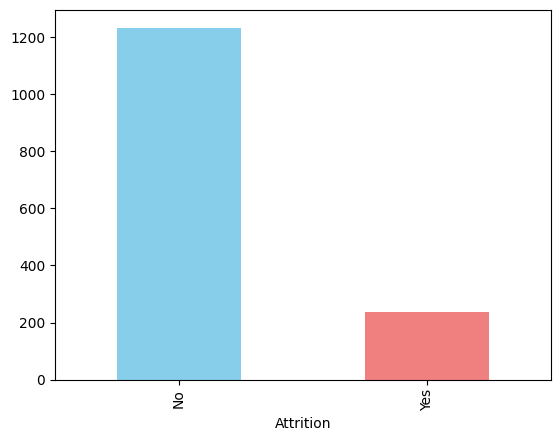

In [41]:
data['Attrition'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral']);

### 1-2-1. 이상치 및 결측치 확인

In [49]:
## 결측치 확인
data.isna().sum()

Unnamed: 0                  0
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsBeforeCompany          0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
DailyRateG

In [51]:
# 이상치 확인

In [43]:
# IQR 기반으로 Outlier 값 조회 메소드

def is_outlier(data, whis=1.5):
    """
    IQR 기반으로 Outlier 값 조회 메소드
    parameter
        data: outlier를 찾을 데이터
        whis: IQR에 몇배를 극단치 계산에 사용할 지 비율. rate를 크게하면 outlier범위를 넓게 잡는다. 작게 주면 범위를 좁게 잡는다.
    return
        bool type ndarray: 각 원소별 outlier 여부 (True: Outlier(이상치), False: 정상범위값)
    """
    q1 = np.quantile(data, q=0.25)
    q3 = np.quantile(data, q=0.75)
    IQR = q3 - q1
    return (data < q1 - IQR * whis) | (data > q3 + IQR * whis)


def get_normal_range(data, whis=1.5):
    """
    IQR 기반으로 정상범위 조회 메소드
    parameter
        data: 조회할 대상 데이터
        whis: IQR에 몇배를 극단치 계산에 사용할 지 비율. rate를 크게하면 outlier범위를 넓게 잡는다. 작게 주면 범위를 좁게 잡는다.
    return
        tuple: (lower_bound, upper_bound) - 정상범위의 하한값과 상한값
    """
    q1 = np.nanquantile(data, q=0.25)
    q3 = np.nanquantile(data, q=0.75)
    IQR = q3 - q1
    lower_bound = q1 - IQR * whis
    upper_bound = q3 + IQR * whis
    return lower_bound, upper_bound

In [44]:
## 시각화 (number 타입만)
### 나눠서 그리기 위해 컬럼이름들 조회
c = data.select_dtypes(include=[np.number]).drop(columns=data.columns[0]).columns
len(c)

22

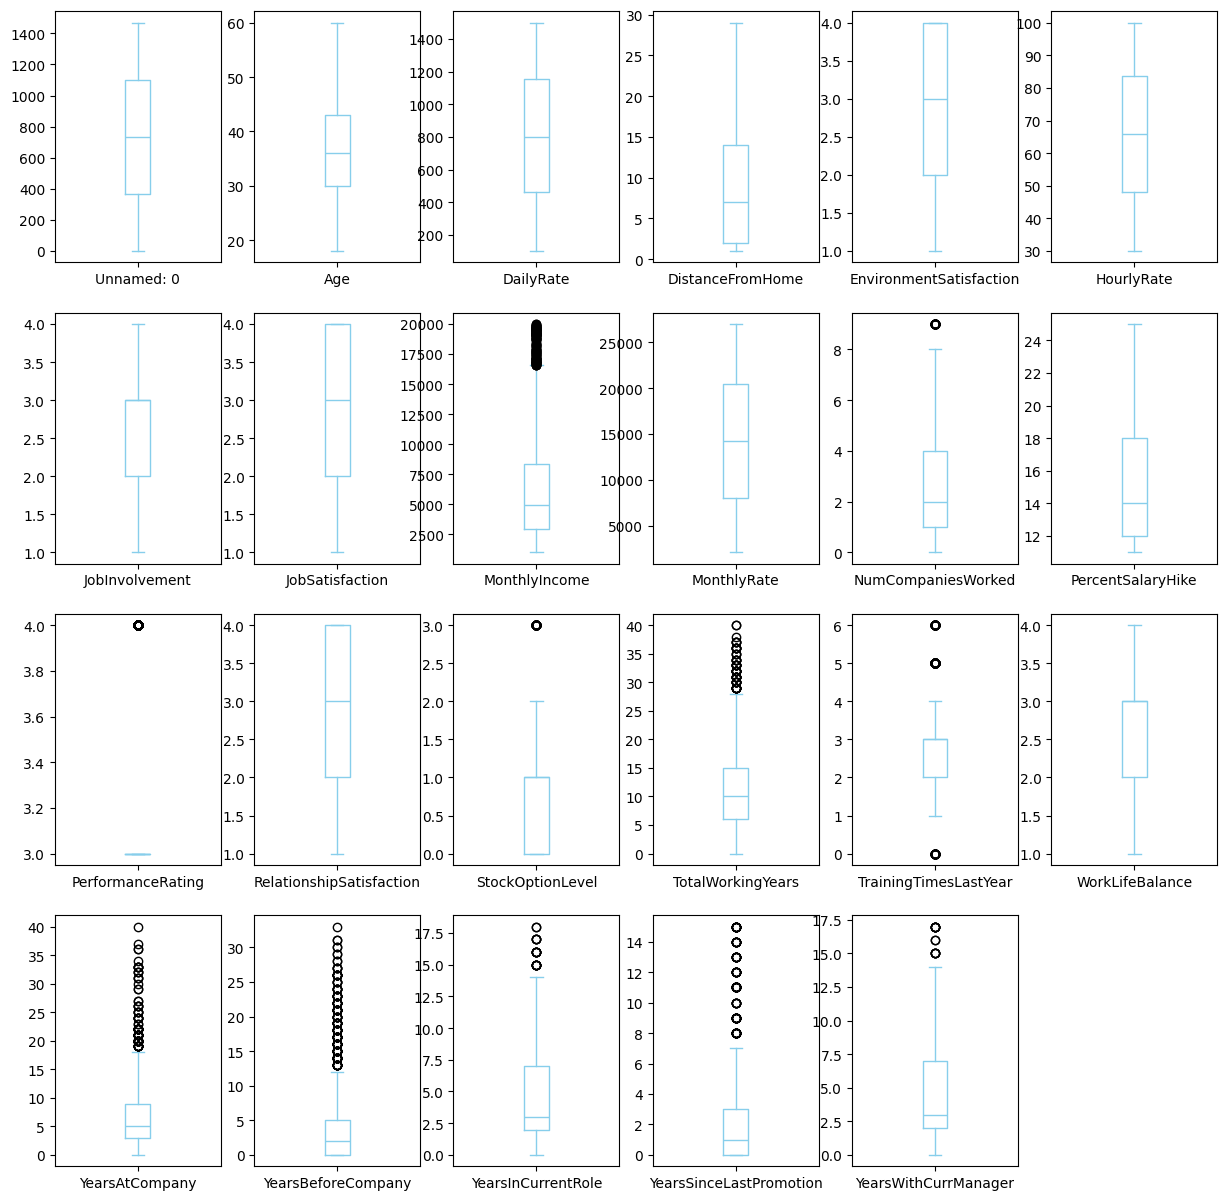

In [47]:
# subplots=True, layout=(3, 4): 3행 4열로 나눠서
data.select_dtypes(include=[np.number]).plot(
    kind='box', 
    subplots=True, 
    layout=(4, 6), 
    figsize=(15, 15), 
    color='skyblue');

### 1-3. 데이터셋 준비

In [53]:
# 범주형 변수 원-핫 인코딩
data = pd.get_dummies(data, drop_first=True)

# 타겟 변수와 특성 분리
X = data.drop('Attrition_Yes', axis=1)
y = data['Attrition_Yes']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 1-4. 모델 학습

In [56]:
# RandomForest 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

### 1-5. 모델 예측 및 평가

In [57]:
# 예측
y_pred = rf_model.predict(X_test_scaled)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

       False       0.88      1.00      0.93       255
        True       0.80      0.10      0.18        39

    accuracy                           0.88       294
   macro avg       0.84      0.55      0.56       294
weighted avg       0.87      0.88      0.83       294



### 1-5. 특성 중요도 확인

In [59]:
# 특성 중요도 확인
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)
print("\nTop 10 Important Features:")
print(feature_importance)


Top 10 Important Features:
              feature  importance
8       MonthlyIncome    0.053388
51       OverTime_Yes    0.043810
15  TotalWorkingYears    0.036335
1                 Age    0.036108
9         MonthlyRate    0.034711
18     YearsAtCompany    0.034267
2           DailyRate    0.034166
0          Unnamed: 0    0.032696
5          HourlyRate    0.032112
3    DistanceFromHome    0.029057


### 1-5. 특성 중요도 시각화

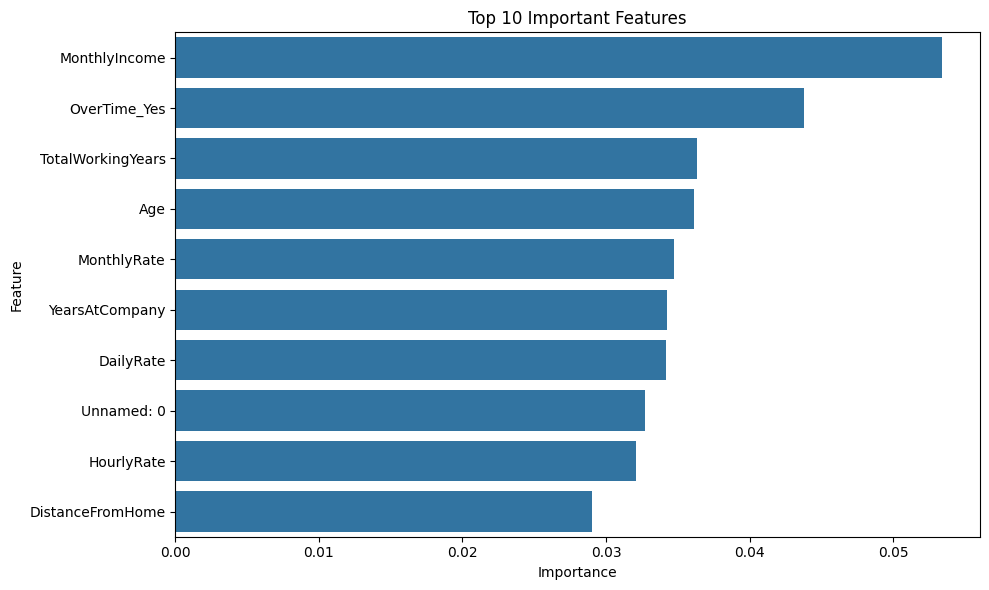

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 상위 10개 중요 특성 시각화
sns.barplot(x='importance', y='feature', data=feature_importance)

# 제목과 축 레이블 설정
plt.title('Top 10 Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')

# 그래프 표시
plt.tight_layout()
plt.show()